<a href="https://colab.research.google.com/github/RikiyaT/Algorithm-and-Data-Structure-Course/blob/main/ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install obp
!pip install matplotlib

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
from pathlib import Path
from joblib import delayed, Parallel
from tqdm import tqdm
import numpy as np
from pandas import DataFrame
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
import yaml
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy,
)
from obp.ope import (
    DirectMethod, DoublyRobust, DoublyRobustWithShrinkageTuning,
    InverseProbabilityWeighting, OffPolicyEvaluation, RegressionModel,
    SelfNormalizedDoublyRobust, SelfNormalizedInverseProbabilityWeighting,
    SwitchDoublyRobustTuning
)
from obp.policy import IPWLearner
from obp.policy import NNPolicyLearner

In [23]:
noise_list={0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0}
n_runs = 10
n_rounds=10000

In [24]:
se_df_list = []
for noise in noise_list:
  se_list = []
  dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=10,
    reward_type='continuous',
    beta=3,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
    reward_std=noise,
  )
  train_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=5000)
  test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=100000)

#Changed learner to NNPolicyLeaner, off_policy_objective is set to ipw.
  ipw_learner = NNPolicyLearner(
      n_actions=dataset.n_actions,
      dim_context=10,
      off_policy_objective='ipw'
  )

  ipw_learner.fit(
    context=train_bandit_data["context"],
    action=train_bandit_data["action"],
    reward=train_bandit_data["reward"],
    pscore=train_bandit_data["pscore"],
  )
  value_of_ipw = dataset.calc_ground_truth_policy_value(
    expected_reward=test_bandit_data["expected_reward"],
    action_dist=ipw_learner.predict(
      context=test_bandit_data["context"],
    ),
  )

  for _ in tqdm(range(n_runs), desc=f"noise={noise}..."):

    validation_bandit_data = dataset.obtain_batch_bandit_feedback(
      n_rounds=n_rounds
    )

    pi_val = ipw_learner.predict(
      context=validation_bandit_data["context"],
    )

    #base model changed to LinearRegression
    reg_model = RegressionModel(
      n_actions=dataset.n_actions,
      base_model=LinearRegression()
    )
    estimated_rewards = reg_model.fit_predict(
        context=validation_bandit_data["context"],
        action=validation_bandit_data["action"],
        reward=validation_bandit_data["reward"],
        random_state=12345,
    )
    ope = OffPolicyEvaluation(
      bandit_feedback=validation_bandit_data,
      ope_estimators=[
          InverseProbabilityWeighting(estimator_name="IPS"),
          DirectMethod(estimator_name="DM"),
          DoublyRobust(estimator_name="DR"),
      ]
    )
    squared_errors = ope.evaluate_performance_of_estimators(
        ground_truth_policy_value=value_of_ipw,
        action_dist=pi_val,
        estimated_rewards_by_reg_model=estimated_rewards,
        metric="se",
    )
    se_list.append(squared_errors)
  max_iw = (pi_val[
      np.arange(validation_bandit_data["n_rounds"]),
      validation_bandit_data["action"],
      0
  ] / validation_bandit_data["pscore"]).max()
  tqdm.write(f"maximum importance weight={np.round(max_iw, 5)}\n")
  se_df = DataFrame(DataFrame(se_list).stack())\
      .reset_index(1).rename(columns={"level_1": "est", 0: "se"})
  se_df["noise"] = noise
  se_df_list.append(se_df)
  tqdm.write("=====" * 15)

result_df = pd.concat(se_df_list).reset_index(level=0)

noise=0.5...: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


maximum importance weight=78.85095



noise=1.0...: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


maximum importance weight=83.28175



noise=2.0...: 100%|██████████| 10/10 [00:01<00:00,  8.85it/s]


maximum importance weight=87.83183



noise=2.5...: 100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


maximum importance weight=116.24552



noise=1.5...: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


maximum importance weight=83.28175



noise=3.0...: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


maximum importance weight=116.24552



noise=3.5...: 100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


maximum importance weight=96.18299



noise=4.0...: 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


maximum importance weight=116.24552



In [25]:
import seaborn as sns

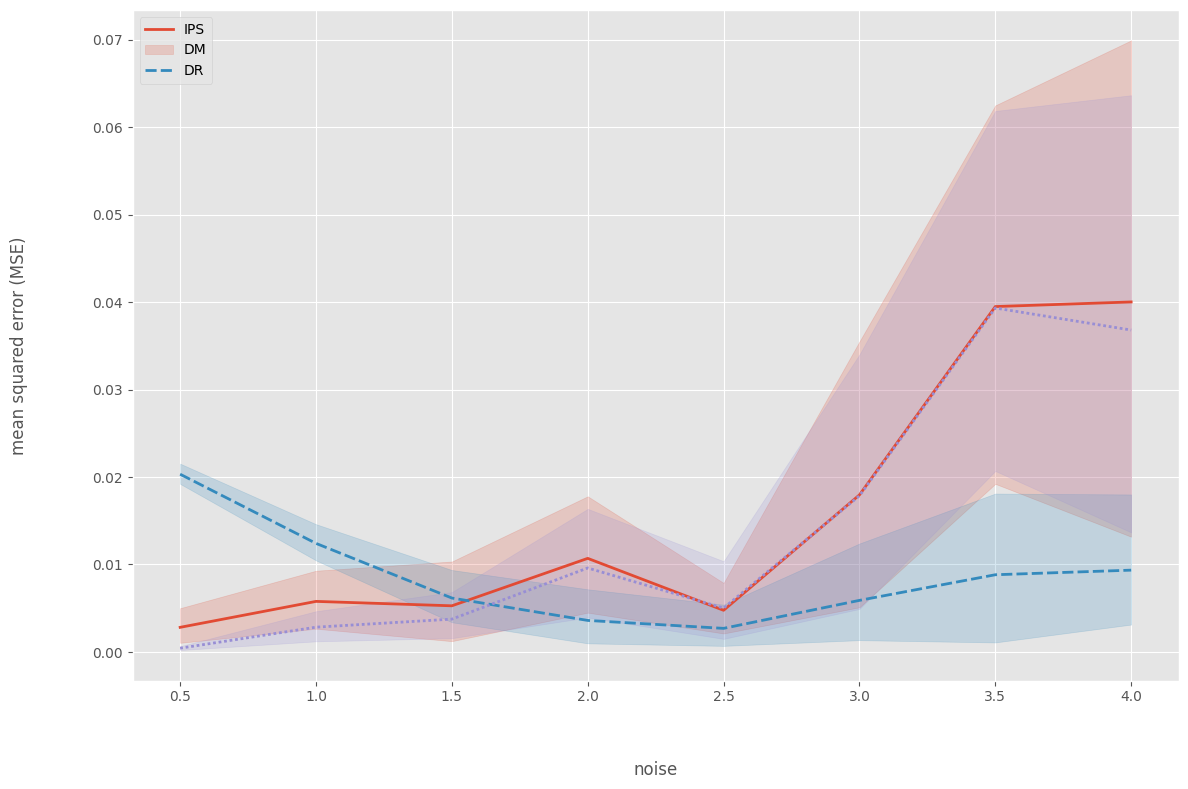

In [27]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8), tight_layout=True)
sns.lineplot(
    linewidth=2,
    legend=False,
    style="est",
    x="noise",
    y="se",
    hue="est",
    ax=ax,
    data=result_df,
)

ax.legend(["IPS", "DM", "DR"], loc="upper left")

ax.set_yscale("linear")
ax.set_ylabel("mean squared error (MSE)")
ax.tick_params(axis="y")
ax.yaxis.set_label_coords(-0.1, 0.5)

ax.set_xscale("linear")
ax.set_xlabel("noise")
ax.set_xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
ax.set_xticklabels([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
ax.xaxis.set_label_coords(0.5, -0.12)